# Sensitivity Analysis to the key parameter Pr_R in the M. aeruginosa NIES298 Resistant Subpopulation Model.

In [1]:
#import packages

import import_ipynb
import pandas as pd
import numpy as np
import random as rd
from scipy.integrate import odeint
import multiprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from RSMfunctions import combined_variance
from RSMfunctions import maxvalue

# set up dataframe display
pd.options.display.max_columns=1000

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
importing Jupyter notebook from RSMfunctions.ipynb


In [2]:
#Import Microcystis abundances
Microcystis_df = pd.read_csv(
    '../Data/MaLMM01 Batch Concentrations.csv')
Microcystis = Microcystis_df.astype(float)
Microcystis['Host26a26_log10']=np.log10(Microcystis['Host26a26'])
Microcystis['Host26a19_log10']=np.log10(Microcystis['Host26a19'])
Microcystis['Host19a26_log10']=np.log10(Microcystis['Host19a26'])
Microcystis['Host19a19_log10']=np.log10(Microcystis['Host19a19'])
print("Microcystis aeruginosa abundances: \n", Microcystis)

Microcystis aeruginosa abundances: 
    Day     Host26a26     Host26a19    Host19a26    Host19a19  Host26a26_log10  \
0  0.0  1.420016e+06  1.386509e+06  1400926.333  1394536.667         6.152293   
1  1.0  1.535596e+06  1.285988e+06  2171949.000  1815200.333         6.186277   
2  2.0  1.496973e+06  1.564002e+06  2196945.000  2199203.333         6.175214   
3  3.0  9.442783e+05  1.423130e+06  1419124.667  2439424.667         5.975100   
4  4.0  7.438033e+05  1.051991e+06  1620374.667  1763624.667         5.871458   
5  5.0  6.531250e+05  9.366787e+05  2015973.000  1781853.000         5.814996   
6  6.0  5.651557e+05  7.318073e+05  2721937.667  2287325.333         5.752168   
7  7.0  5.031790e+05  6.313983e+05  3509122.667  3065203.667         5.701723   
8  8.0  4.432190e+05  5.727367e+05  4395083.667  3864520.667         5.646618   

   Host26a19_log10  Host19a26_log10  Host19a19_log10  
0         6.141923         6.146415         6.144430  
1         6.109237         6.336850       

In [3]:
#Import Ma-LMM01 phage abundances
VLP = pd.read_csv(
    '../Data/VLP.csv')
VLP['VLP26a26_log10']=np.log10(VLP['VLP26a26'])
VLP['VLP26a19_log10']=np.log10(VLP['VLP26a19'])
VLP['VLP19a26_log10']=np.log10(VLP['VLP19a26'])
VLP['VLP19a19_log10']=np.log10(VLP['VLP19a19'])
print("Ma-LMM01 VLP abundances: \n", VLP)

Ma-LMM01 VLP abundances: 
    Day     VLP26a26     VLP26a19     VLP19a26     VLP19a19  VLP26a26_log10  \
0    0   10200000.0    9930000.0    4950000.0    6670000.0        7.008600   
1    4  163000000.0  119000000.0  148000000.0  154000000.0        8.212188   
2    8   97600000.0  162000000.0  367000000.0  346000000.0        7.989450   

   VLP26a19_log10  VLP19a26_log10  VLP19a19_log10  
0        6.996949        6.694605        6.824126  
1        8.075547        8.170262        8.187521  
2        8.209515        8.564666        8.539076  


In [4]:
#Define parameters for susceptible host subpopulation
mu = .07
phi = 1e-8
lamb = 2
beta = 120
Pr_S = 1

#Define parameters for resistant host supopulation
muR = .28
lambR = 2
betaR = 120
phiR = 1e-6,1e-7,1e-15,1e-10
Pr_R = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

#Define initial conditions for the resistant population model
#Note these are derived from experimentally derived abundances
S0 = Microcystis['Host26a26'][0], Microcystis['Host26a19'][0],Microcystis['Host19a26'][0], Microcystis['Host19a19'][0]
I0 = 0
V0 = VLP['VLP26a26'][0],VLP['VLP26a19'][0],VLP['VLP19a26'][0],VLP['VLP19a19'][0]
R0 = 800000,550000,500000,100000,90000,80000,70000,60000,50000,40000,30000
R0_19 = 800000,700000,600000,550000,430000,300000,200000,100000,90000,80000,70000
IR0 = 0

#Define resistant subpopulation model function
def RSM(y,t,mu,phi,beta,lamb,phiR,betaR,lambR,Pr_S,Pr_R):
    S,I,V,R,IR = y
    dSdt = (mu*S) - (phi*S*V) + (lamb*(I)*(1-Pr_S))
    dIdt = (phi*S*V) - (lamb*I)
    dRdt = (mu*R) - (phiR*R*V) + (lambR*(IR)*(1-Pr_R))
    dIRdt = (phiR*R*V) - (lambR*IR)
    dVdt = ((beta*I*lamb*Pr_S) + (betaR*IR*lambR*Pr_R)) - ((phi*S+phiR*R)*V)
    return np.array([dSdt,dIdt,dVdt,dRdt,dIRdt])

#Define function to fit Pr_R using the resistant subpopulation model
def solver(model,mu,phi,beta,lamb,phiR,betaR,lambR,Pr_S,PR_R):
    Ss,Is,Vs,Rr,Ir = [],[],[],[],[]
    ODE = np.array([odeint(RSM, model, t, args=(mu,phi,beta,lamb,phiR,betaR,lambR,Pr_S,PR_R[i])) for i in range(11)])
    pd.Series([Ss.append(ODE[i,:,0]) for i in range(11)])
    pd.Series([Is.append(ODE[i,:,1]) for i in range(11)])
    pd.Series([Vs.append(ODE[i,:,2]) for i in range(11)])
    pd.Series([Rr.append(ODE[i,:,3]) for i in range(11)])
    pd.Series([Ir.append(ODE[i,:,4]) for i in range(11)])
    total = [pd.Series((Ss[i]+Is[i]+Rr[i]+Ir[i])) for i in range(11)]
    viruses = [pd.Series(Vs[i]) for i in range(11)]
    ode_df = pd.DataFrame(total)
    ode_df_transpose= ode_df.transpose()
    ode_df_hostlog = np.log10(ode_df_transpose)
    viruses_df = pd.DataFrame(viruses)
    viruses_df_transpose = viruses_df.transpose()
    ode_df_VLPlog = np.log10( viruses_df_transpose)
    return ode_df_hostlog,ode_df_VLPlog
def solverR(model,mu,phi,beta,lamb,phiR,betaR,lambR,Pr_S,PR_R):
    Ss,Is,Vs,Rr,Ir = [],[],[],[],[]
    ODE = np.array([odeint(RSM, model, t, args=(mu,phi,beta,lamb,phiR,betaR,lambR,Pr_S,PR_R[i])) for i in range(11)])
    pd.Series([Ss.append(ODE[i,:,0]) for i in range(11)])
    pd.Series([Is.append(ODE[i,:,1]) for i in range(11)])
    pd.Series([Vs.append(ODE[i,:,2]) for i in range(11)])
    pd.Series([Rr.append(ODE[i,:,3]) for i in range(11)])
    pd.Series([Ir.append(ODE[i,:,4]) for i in range(11)])
    total = [pd.Series((Ss[i]+Is[i]+Rr[i]+Ir[i])) for i in range(11)]
    viruses = [pd.Series(Vs[i]) for i in range(11)]
    ode_df = pd.DataFrame(total)
    ode_df_transpose= ode_df.transpose()
    ode_df_hostlog = np.log10(ode_df_transpose)
    viruses_df = pd.DataFrame(viruses)
    viruses_df_transpose = viruses_df.transpose()
    ode_df_VLPlog = np.log10( viruses_df_transpose)
    return ode_df_hostlog,ode_df_VLPlog

In [5]:
"""This portion of the code is for fitting the key parameter PrR."""

#Define list of initial conditions that will be input into the ODE 
y0_26a26 = [[S0[0]-R0[i],I0,V0[0],R0[i],IR0] for i in range(11)]

y0_26a19 = [[S0[1]-R0[i],I0,V0[1],R0[i],IR0] for i in range(11)]

y0_19a26 = [[S0[2]-R0_19[i],I0,V0[2],R0_19[i],IR0] for i in range(11)]

y0_19a19 = [[S0[3]-R0_19[i],I0,V0[3],R0_19[i],IR0] for i in range(11)]

#Time domain
tmin,tmax = 0,8
delta = 0.001
nsteps = (tmax-tmin)/delta
t = np.linspace(tmin,tmax,int(nsteps))

#Perform ODE for host

host26a26_ode, host26a19_ode, host19a26_ode, host19a19_ode = [], [], [], []
np.array([host26a26_ode.append(solver(y0_26a26[i],mu,phi,beta,lamb,phiR[0],betaR,lambR,Pr_S,Pr_R)[0]) for i in range(11)])
np.array([host26a19_ode.append(solver(y0_26a19[i],mu,phi,beta,lamb,phiR[1],betaR,lambR,Pr_S,Pr_R)[0]) for i in range(11)])
np.array([host19a26_ode.append(solverR(y0_19a26[i],muR,phi,beta,lamb,phiR[2],betaR,lambR,Pr_S,Pr_R)[0]) for i in range(11)])
np.array([host19a19_ode.append(solverR(y0_19a19[i],muR,phi,beta,lamb,phiR[3],betaR,lambR,Pr_S,Pr_R)[0]) for i in range(11)])

#Perform ODE for virus
VLP26a26_ode, VLP26a19_ode, VLP19a26_ode, VLP19a19_ode = [], [], [], []
np.array([VLP26a26_ode.append(solver(y0_26a26[i],mu,phi,beta,lamb,phiR[0],betaR,lambR,Pr_S,Pr_R)[1]) for i in range(11)])
np.array([VLP26a19_ode.append(solver(y0_26a19[i],mu,phi,beta,lamb,phiR[1],betaR,lambR,Pr_S,Pr_R)[1]) for i in range(11)])
np.array([VLP19a26_ode.append(solverR(y0_19a26[i],muR,phi,beta,lamb,phiR[2],betaR,lambR,Pr_S,Pr_R)[1]) for i in range(11)])
np.array([VLP19a19_ode.append(solverR(y0_19a19[i],muR,phi,beta,lamb,phiR[3],betaR,lambR,Pr_S,Pr_R)[1]) for i in range(11)])

#define the host and virus 
host_26 =  Microcystis['Host26a26'],Microcystis['Host26a19'],Microcystis['Host26a26_log10'],Microcystis['Host26a19_log10']
host_19 = Microcystis['Host19a26'], Microcystis['Host19a19'], Microcystis['Host19a26_log10'],Microcystis['Host19a19_log10']
VLP_26 = VLP['VLP26a26'],VLP['VLP26a19'],VLP['VLP26a26_log10'],VLP['VLP26a19_log10']
VLP_19 = VLP['VLP19a26'], VLP['VLP19a19'], VLP['VLP19a26_log10'],VLP['VLP19a19_log10']

#Detemine Variance in model taking into account both the host and the virus
combinedvariances_26a26, combinedvariances_26a19, combinedvariances_19a26, combinedvariances_19a19 =[],[],[],[]
combineddf_26a26, combineddf_26a19, combineddf_19a26, combineddf_19a19 = [],[],[],[]
[combinedvariances_26a26.append(combined_variance(host_26[2],VLP_26[2],host26a26_ode[i][j], VLP26a26_ode[i][j],Microcystis,VLP)) for i in range(11) for j in range(11)]
[combinedvariances_26a19.append(combined_variance(host_26[3],VLP_26[3],host26a19_ode[i][j],VLP26a19_ode[i][j],Microcystis,VLP)) for i in range(11) for j in range(11)]
[combinedvariances_19a26.append(combined_variance(host_19[2],VLP_19[2],host19a26_ode[i][j],VLP19a26_ode[i][j],Microcystis,VLP)) for i in range(11) for j in range(11)]
[combinedvariances_19a19.append(combined_variance(host_19[3],VLP_19[3],host19a19_ode[i][j],VLP19a19_ode[i][j],Microcystis,VLP)) for i in range(11) for j in range(11)]
combined_split_variances_26a26 = np.array_split(combinedvariances_26a26, 11)
combined_split_variances_26a19 = np.array_split(combinedvariances_26a19, 11)
combined_split_variances_19a26 = np.array_split(combinedvariances_19a26, 11)
combined_split_variances_19a19 = np.array_split(combinedvariances_19a19, 11)
[combineddf_26a26.append(pd.DataFrame(combined_split_variances_26a26[i],columns=['Likelihood'])) for i in range(11)]
[combineddf_26a19.append(pd.DataFrame(combined_split_variances_26a19[i],columns=['Likelihood'])) for i in range(11)]
[combineddf_19a26.append(pd.DataFrame(combined_split_variances_19a26[i],columns=['Likelihood'])) for i in range(11)]
[combineddf_19a19.append(pd.DataFrame(combined_split_variances_19a19[i],columns=['Likelihood'])) for i in range(11)]

#Orient data in appropriate manner for output 
def orientdata26_Pr_R(data):
    likelihood26 = []
    likelihood26 = np.array([(data[i]['Likelihood']) for i in range(11)])
    likelihood_df26 = pd.DataFrame(likelihood26, columns=[str(i) for i in Pr_R], index= ['700000','550000','500000','100000','90000','80000','70000','60000','50000','40000','30000'])
    return likelihood_df26

def orientdata19_Pr_R(data):
    likelihood19 = []
    likelihood19 = np.array([(data[i]['Likelihood']) for i in range(11)])
    likelihood_df19 = pd.DataFrame(likelihood19, columns=[str(i) for i in Pr_R], index= ['800000','700000','600000','500000','430000','300000','200000','100000','90000','80000','70000'])
    return likelihood_df19

orientdata_26a26 = orientdata26_Pr_R(combineddf_26a26)
orientdata_26a19 = orientdata26_Pr_R(combineddf_26a19)
orientdata_19a26 = orientdata19_Pr_R(combineddf_19a26)
orientdata_19a19 = orientdata19_Pr_R(combineddf_19a19)

#Print the highest likelihood value achieved and at what betaR this occurs
print("The highest likelihood value for the 26a26 treatment is: ", (maxvalue(orientdata_26a26)[0]), "and occurs at a Pr_R of: ", (maxvalue(orientdata_26a26)[1]))
print("The highest likelihood value for the 26a19 treatment is: ", (maxvalue(orientdata_26a19)[0]), "and occurs at a Pr_R of: ", (maxvalue(orientdata_26a19)[1]))
print("The highest likelihood value for the 19a26 treatment is: ", (maxvalue(orientdata_19a26)[0]), "and occurs at a Pr_R of: ", (maxvalue(orientdata_19a26)[1]))
print("The highest likelihood value for the 19a19 treatment is: ", (maxvalue(orientdata_19a19)[0]), "and occurs at a Pr_R of: ", (maxvalue(orientdata_19a19)[1]))


The highest likelihood value for the 26a26 treatment is:  0.58 and occurs at a Pr_R of:  0.0
The highest likelihood value for the 26a19 treatment is:  0.78 and occurs at a Pr_R of:  0.0
The highest likelihood value for the 19a26 treatment is:  0.59 and occurs at a Pr_R of:  1.0
The highest likelihood value for the 19a19 treatment is:  0.92 and occurs at a Pr_R of:  1.0


In [6]:
print(orientdata_19a19)

             0.0       0.1       0.2       0.3       0.4       0.5       0.6  \
800000  0.060776  0.063187  0.065661  0.068197  0.070795  0.073456  0.076180   
700000  0.180495  0.186368  0.192333  0.198388  0.204532  0.210760  0.217072   
600000  0.419383  0.429599  0.439837  0.450089  0.460346  0.470599  0.480840   
500000  0.579469  0.590850  0.602140  0.613328  0.624403  0.635352  0.646162   
430000  0.892629  0.897703  0.902308  0.906436  0.910079  0.913232  0.915888   
300000  0.571541  0.562314  0.552890  0.543283  0.533506  0.523573  0.513497   
200000  0.092435  0.088580  0.084826  0.081173  0.077621  0.074171  0.070823   
100000  0.000246  0.000225  0.000206  0.000188  0.000172  0.000157  0.000143   
90000   0.000075  0.000069  0.000062  0.000057  0.000051  0.000046  0.000042   
80000   0.000019  0.000017  0.000015  0.000014  0.000012  0.000011  0.000010   
70000   0.000003  0.000003  0.000003  0.000002  0.000002  0.000002  0.000002   

             0.7       0.8       0.9   

# Plot the results of the Sensitivity Analysis to the key parameter beta in the M. aeruginosa NIES298 Resistant Subpopulation Model.

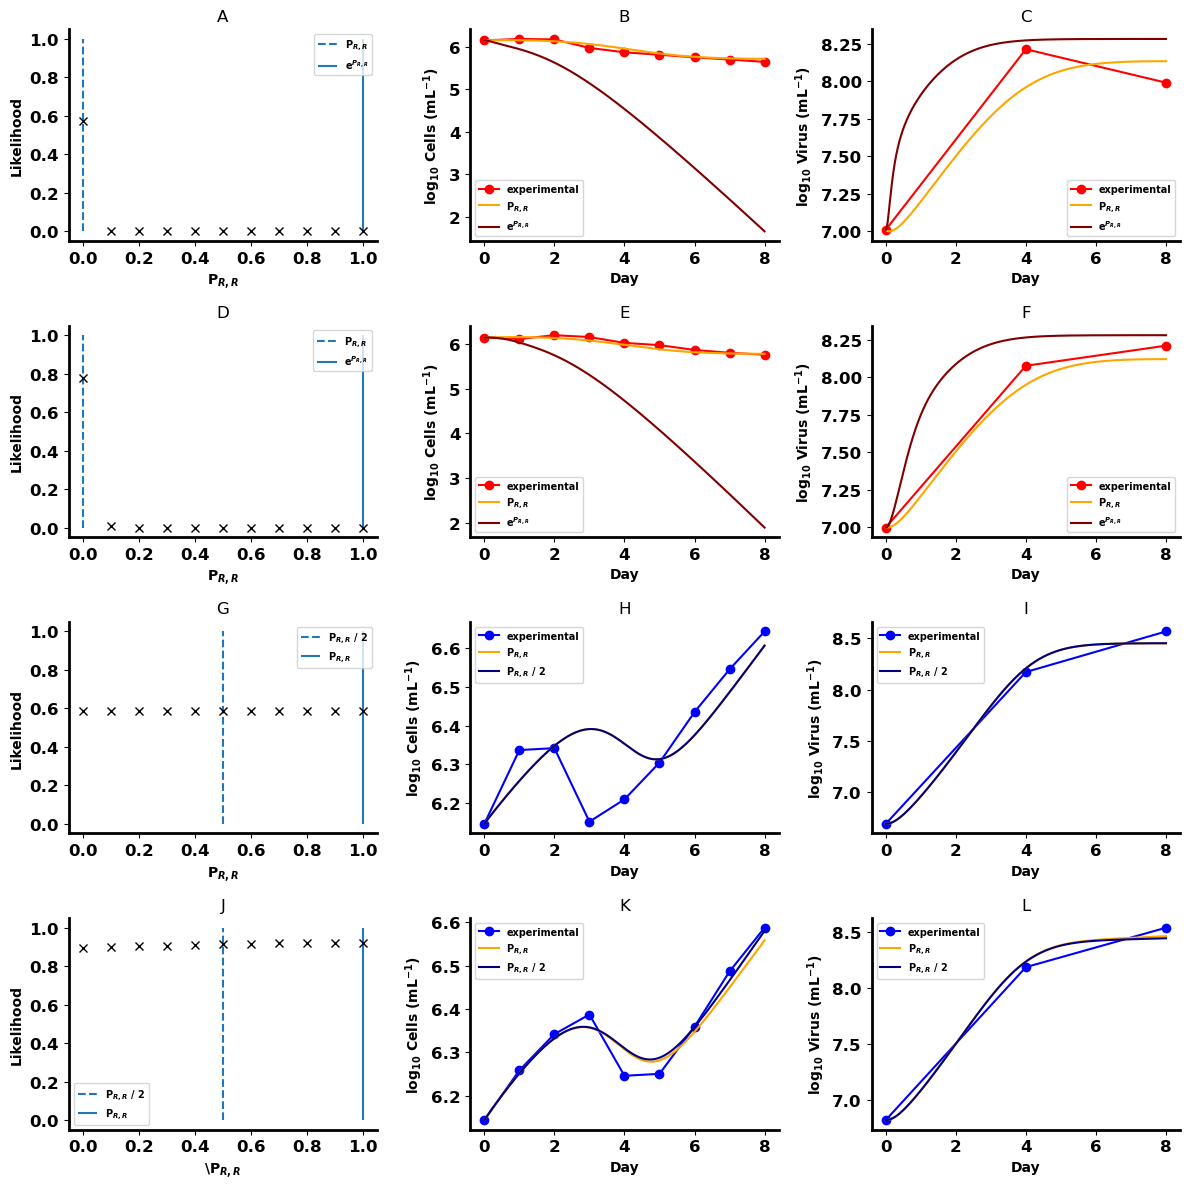

In [8]:
f,ax = plt.subplots(4,3,figsize=[12,12]) # set up axes

#26a26 - panel A
ax[0,0].set_title("A")
ax[0,0].set(xlabel='P$_{R,R}$', ylabel='Likelihood')
ax[0,0].vlines(x=0, ymin=0,ymax=1,ls='--', label='P$_{R,R}$')
ax[0,0].vlines(x=1,ymin=0,ymax=1, label='e$^{P_{R,R}}$')
#26a26 - panel B
ax[0,1].set_title("B")
ax[0,1].set(xlabel='Day', ylabel='log$_{10}$ Cells (mL$^{-1}$)')
ax[0,1].plot(Microcystis.Day, Microcystis.Host26a26_log10, 'red', marker='o',label='experimental')
ax[0,1].plot(t, host26a26_ode[2][0], 'orange', label='P$_{R,R}$ ') 
ax[0,1].plot(t, host26a26_ode[2][10], 'maroon', label='e$^{P_{R,R}}$') 
#26a26 - panel C
ax[0,2].set_title("C")
ax[0,2].set(xlabel='Day', ylabel='log$_{10}$ Virus (mL$^{-1}$)')
ax[0,2].plot(VLP.Day, VLP.VLP26a26_log10, 'red', marker='o',label='experimental')
ax[0,2].plot(t, VLP26a26_ode[2][0], 'orange', label='P$_{R,R}$ ') 
ax[0,2].plot(t, VLP26a26_ode[2][10], 'maroon', label='e$^{P_{R,R}}$')

#26a19 - panel D
ax[1,0].set_title("D")
ax[1,0].set(xlabel='P$_{R,R}$', ylabel='Likelihood')
ax[1,0].vlines(x=0, ymin=0,ymax=1,ls='--', label='P$_{R,R}$ ')
ax[1,0].vlines(x=1,ymin=0,ymax=1, label='e$^{P_{R,R}}$')
#26a19 - panel E
ax[1,1].set_title("E")
ax[1,1].set(xlabel='Day', ylabel='log$_{10}$ Cells (mL$^{-1}$)')
ax[1,1].plot(Microcystis.Day, Microcystis.Host26a19_log10, 'red', marker='o',label='experimental')
ax[1,1].plot(t, host26a19_ode[2][0], 'orange', label='P$_{R,R}$ ') 
ax[1,1].plot(t, host26a19_ode[2][10], 'maroon', label='e$^{P_{R,R}}$ ') 
#26a19 - panel F
ax[1,2].set_title("F")
ax[1,2].set(xlabel='Day', ylabel='log$_{10}$ Virus (mL$^{-1}$)')
ax[1,2].plot(VLP.Day, VLP.VLP26a19_log10, 'red', marker='o',label='experimental')
ax[1,2].plot(t, VLP26a19_ode[2][0], 'orange', label='P$_{R,R}$ ') 
ax[1,2].plot(t, VLP26a19_ode[2][10], 'maroon', label='e$^{P_{R,R}}$') 

#19a26 - panel G
ax[2,0].set_title("G")
ax[2,0].set(xlabel='P$_{R,R}$', ylabel='Likelihood')
ax[2,0].vlines(x=0.5, ymin=0,ymax=1,ls='--', label='P$_{R,R}$ / 2')
ax[2,0].vlines(x=1,ymin=0,ymax=1, label='P$_{R,R}$ ')
#19a26 - panel H
ax[2,1].set_title("H")
ax[2,1].set(xlabel='Day', ylabel='log$_{10}$ Cells (mL$^{-1}$)')
ax[2,1].plot(Microcystis.Day, Microcystis.Host19a26_log10, 'blue', marker='o',label='experimental')
ax[2,1].plot(t, host19a26_ode[4][10], 'orange', label='P$_{R,R}$') 
ax[2,1].plot(t, host19a26_ode[4][5], 'navy', label='P$_{R,R}$ / 2') 
#19a26 - panel I
ax[2,2].set_title("I")
ax[2,2].set(xlabel='Day', ylabel='log$_{10}$ Virus (mL$^{-1}$)')
ax[2,2].plot(VLP.Day, VLP.VLP19a26_log10, 'blue', marker='o',label='experimental')
ax[2,2].plot(t, VLP19a26_ode[4][10], 'orange', label='P$_{R,R}$ ') 
ax[2,2].plot(t, VLP19a26_ode[4][5], 'navy', label='P$_{R,R}$ / 2') 

#19a19 - panel J
ax[3,0].set_title("J")
ax[3,0].set(xlabel='\P$_{R,R}$', ylabel='Likelihood')
ax[3,0].vlines(x=0.5, ymin=0,ymax=1,ls='--', label='P$_{R,R}$ / 2')
ax[3,0].vlines(x=1,ymin=0,ymax=1, label='P$_{R,R}$')
#19a19 - panel K
ax[3,1].set_title("K")
ax[3,1].set(xlabel='Day', ylabel='log$_{10}$ Cells (mL$^{-1}$)')
ax[3,1].plot(Microcystis.Day, Microcystis.Host19a19_log10, 'blue', marker='o',label='experimental')
ax[3,1].plot(t, host19a19_ode[4][10], 'orange', label='P$_{R,R}$ ') 
ax[3,1].plot(t, host19a19_ode[4][5], 'navy', label='P$_{R,R}$ / 2') 
#19a19 - panel L
ax[3,2].set_title("L")
ax[3,2].set(xlabel='Day', ylabel='log$_{10}$ Virus (mL$^{-1}$)')
ax[3,2].plot(VLP.Day, VLP.VLP19a19_log10, 'blue', marker='o',label='experimental')
ax[3,2].plot(t, VLP19a19_ode[4][10], 'orange', label='P$_{R,R}$ ') 
ax[3,2].plot(t, VLP19a19_ode[4][5], 'navy', label='P$_{R,R}$ / 2') 

for i in Pr_R:
    ax[0,0].plot(i,(orientdata_26a26)[str(i)]['500000'],'black',marker='x') 
    ax[1,0].plot(i,(orientdata_26a19)[str(i)]['500000'],'black',marker='x') 
    ax[2,0].plot(i,(orientdata_19a26)[str(i)]['430000'],'black',marker='x')
    ax[3,0].plot(i,(orientdata_19a19)[str(i)]['430000'],'black',marker='x')


for ax in ax.flat:
    ax.legend(loc='best',fontsize=7)
    ax.tick_params(labelsize=12)
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
fontproperties = {'family':'Times New Roman'}
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"

plt.tight_layout()
plt.show()
f.savefig('sf12.png')